# HEALTHCARE NO-SHOW PREDICTION

### Import Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             classification_report)
import sklearn.metrics as met
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

import shap
shap.initjs()


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [2]:
df = pd.read_csv("KaggleV2-May-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Data Cleaning

In [4]:
print(df.shape)
print(df.columns)

(110527, 14)
Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')


In [6]:
df.isna().sum()

PatientId         0
AppointmentId     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SmsReceived       0
NoShow            0
dtype: int64

**Extracting date from Scheduled Day & Appointment Day**

In [78]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"]) 
df['ScheduledDate'] = df['ScheduledDay'].dt.date 
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek,AppointmentDayOfWeek,LeadDays,Old_Chronic
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,OldChronic
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,Healthier
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,Healthier
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,Healthier
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,YoungChronic


In [79]:
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"]) 
df['AppointmentDate'] = df['AppointmentDay'].dt.date
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek,AppointmentDayOfWeek,LeadDays,Old_Chronic
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,OldChronic
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,Healthier
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,Healthier
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,Healthier
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0,YoungChronic


**Checking whether any Appointment days are before Scheduled days**

In [10]:
len(df[df["AppointmentDay"] < df["ScheduledDay"]])

38568

In [11]:
df['AppointmentDay'] = df['AppointmentDay'] + pd.Timedelta('1d') - pd.Timedelta('1s')
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,2016-04-29
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,2016-04-29
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,2016-04-29
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,2016-04-29
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,2016-04-29


In [12]:
len(df[ df.AppointmentDay < df.ScheduledDay ])

5

In [13]:
df.drop( df[df.AppointmentDay <= df.ScheduledDay].index, inplace=True)
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,2016-04-29
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,2016-04-29
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,2016-04-29
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,2016-04-29
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,2016-04-29


**Extracting week name for Scheduled day & Appointment day**

In [14]:
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['ScheduledDayOfWeek']=df['ScheduledDay'].dt.date
df['ScheduledDayOfWeek']=pd.to_datetime(df['ScheduledDayOfWeek'])
df['ScheduledDayOfWeek'] = df['ScheduledDayOfWeek'].dt.day_name()
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,2016-04-29,Friday
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,Friday
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,Friday
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,2016-04-29,Friday
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,2016-04-29,Friday


In [15]:
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
df['AppointmentDayOfWeek']=df['AppointmentDay'].dt.date
df['AppointmentDayOfWeek']=pd.to_datetime(df['AppointmentDayOfWeek'])
df['AppointmentDayOfWeek'] = df['AppointmentDayOfWeek'].dt.day_name()
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek,AppointmentDayOfWeek
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,2016-04-29,Friday,Friday
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,Friday,Friday
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,2016-04-29,Friday,Friday
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,2016-04-29,Friday,Friday
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,2016-04-29,Friday,Friday


In [16]:
d_replace = {"Yes": 1, "No": 0}
df = df.replace({"NoShow": d_replace})

**Creating a new Column Lead Days**

In [18]:
df['LeadDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek,AppointmentDayOfWeek,LeadDays
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0


### Data Visualization


In [24]:
df_for_plots=df.copy()

In [25]:
def age_category(age):
    if(age<=15):
        return 1
    elif(age>15 and age<=30):
        return 2
    elif(age>30 and age<=45):
        return 3
    elif(age>45 and age<=60):
        return 4
    elif(age>60):
        return 5

df_for_plots['AgeCategory'] = df_for_plots.apply(lambda x: age_category(x['Age']), axis=1)

In [26]:
def lead_day_category(LeadDay):
    if(LeadDay<=2):
        return 'Within 2 Days'
    elif(LeadDay>2 and LeadDay<=7):
        return 'Within 1 Week'
    elif(LeadDay>7 and LeadDay<=14):
        return 'Within 2 Weeks'
    elif(LeadDay>14 and LeadDay<=21):
        return 'Within 3 Weeks'
    elif(LeadDay>21 and LeadDay<=28):
        return 'Within 4 Weeks'
    elif(LeadDay>28):
        return 'After 1 Month'

In [31]:
df_for_plots['LeadDayCategory'] = df_for_plots.apply(lambda x: lead_day_category(x['LeadDays']), axis=1)

df_lead_days = df_for_plots.groupby(by=['LeadDayCategory', 'NoShow'])['PatientId'].agg(['count']).rename(columns={'count':'LeadDayCount'})
df_lead_days.reset_index(inplace=True)
df_lead_days = df_lead_days[df_lead_days['NoShow']==1]

df_total = df_for_plots[['LeadDayCategory', 'PatientId']]
df_total = df_total.groupby(by='LeadDayCategory')['PatientId'].agg(['count']).rename(columns={'count':'Total'})
df_total.reset_index(inplace=True)

df_lead_days = df_lead_days.merge(df_total, how='left', left_on=['LeadDayCategory'], right_on=['LeadDayCategory'])

df_lead_days['Percent'] = round((df_lead_days['LeadDayCount']*100) / df_lead_days['Total'], 2)
df_lead_days

,LeadDayCategory,NoShow,LeadDayCount,Total,Percent
0,After 1 Month,1,3968,12171,32.60
1,Within 1 Week,1,5057,20247,24.98
2,Within 2 Days,1,4507,50501,8.92
3,Within 2 Weeks,1,3664,12025,30.47
4,Within 3 Weeks,1,2861,8874,32.24
5,Within 4 Weeks,1,2257,6704,33.67


**No-Show Rate by Age Category**

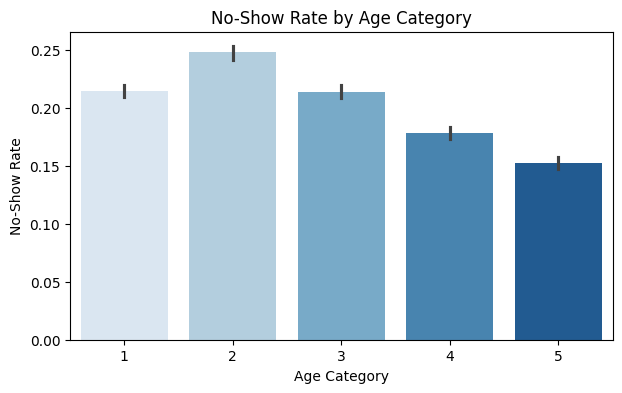

In [28]:
plt.figure(figsize=(7,4))
sns.barplot(data=df_for_plots, x='AgeCategory', y='NoShow', estimator='mean', palette='Blues')
plt.title("No-Show Rate by Age Category")
plt.xlabel("Age Category")
plt.ylabel("No-Show Rate")
plt.show()


**Show vs No-Show**

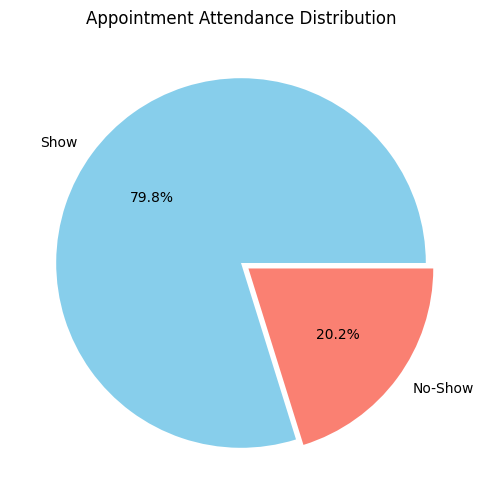

In [45]:
plt.figure(figsize=(6,6))
df_for_plots['NoShow'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Show','No-Show'],
    colors=['skyblue','salmon'],
    explode=[0,0.05]
)
plt.title("Appointment Attendance Distribution")
plt.ylabel("")
plt.show()

**No-Show Rate by Lead Day Category**

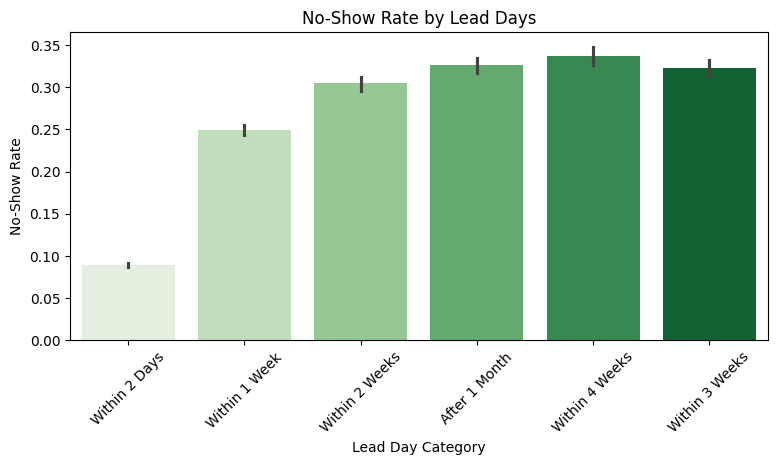

In [32]:
plt.figure(figsize=(9,4))
sns.barplot(data=df_for_plots, x='LeadDayCategory', y='NoShow', estimator='mean', palette='Greens')
plt.title("No-Show Rate by Lead Days")
plt.xlabel("Lead Day Category")
plt.ylabel("No-Show Rate")
plt.xticks(rotation=45)
plt.show()


**No-Show Rate by Weekday**

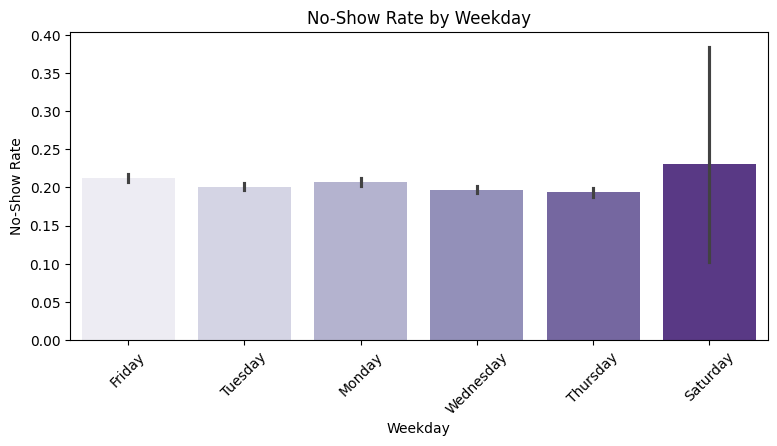

In [34]:
plt.figure(figsize=(9,4))
sns.barplot(data=df_for_plots, x='AppointmentDayOfWeek', y='NoShow', estimator='mean', palette='Purples')
plt.title("No-Show Rate by Weekday")
plt.xlabel("Weekday")
plt.ylabel("No-Show Rate")
plt.xticks(rotation=45)
plt.show()


**Appointments by Gender**

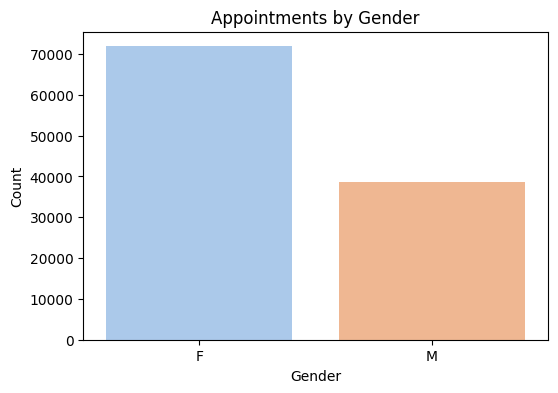

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_for_plots, x='Gender', palette='pastel')
plt.title("Appointments by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


**Lead Days Distribution**

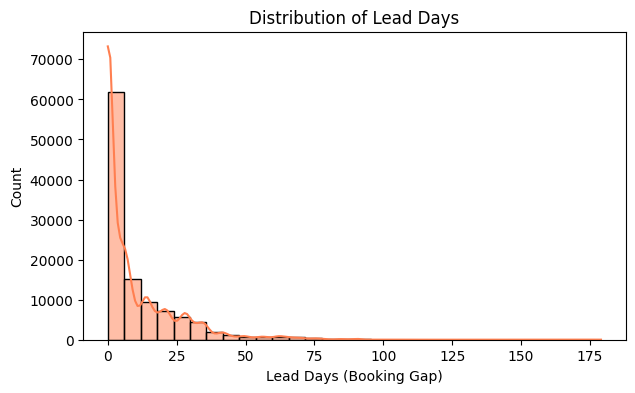

In [36]:
plt.figure(figsize=(7,4))
sns.histplot(df_for_plots['LeadDays'], bins=30, kde=True, color='coral')
plt.title("Distribution of Lead Days")
plt.xlabel("Lead Days (Booking Gap)")
plt.ylabel("Count")
plt.show()


In [38]:
df_for_plots['SmsReceived'] = df_for_plots['SmsReceived'].map({0:'SMS not received', 1:'SMS received'})

In [41]:
df['Old_Chronic'] = np.where(
    ((df['Hypertension']==1) | (df['Diabetes']==1)) & (df['Age']>60),
    'OldChronic',
    np.where(
        ((df['Hypertension']==1) | (df['Diabetes']==1)) & (df['Age']<=60),
        'YoungChronic',
        'Healthier'
    )
)


In [42]:
total_noshow = df[df['NoShow']==1].shape[0]

Pct_Old_Chronic = round(
    df[(df['Old_Chronic']=='OldChronic') & (df['NoShow']==1)].shape[0] / total_noshow * 100, 2
)

Pct_Young_Chronic = round(
    df[(df['Old_Chronic']=='YoungChronic') & (df['NoShow']==1)].shape[0] / total_noshow * 100, 2
)

print("Old Chronic %:", Pct_Old_Chronic)
print("Young Chronic %:", Pct_Young_Chronic)


Old Chronic %: 8.2
Young Chronic %: 10.0


**Correlation Between Important Numeric Columns**

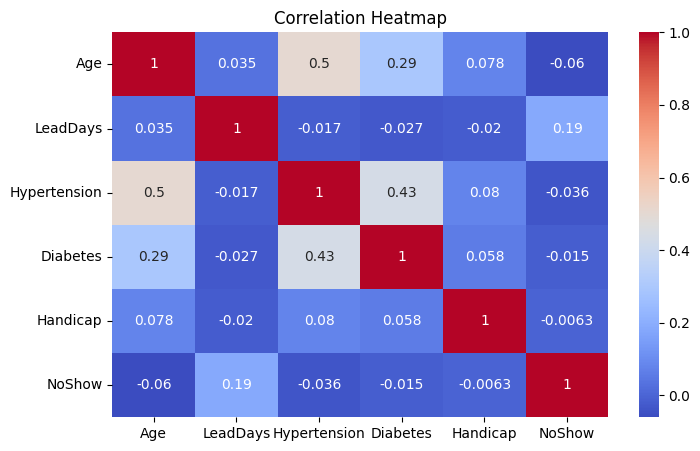

In [44]:
plt.figure(figsize=(8,5))
sns.heatmap(df_for_plots[['Age','LeadDays','Hypertension','Diabetes','Handicap','NoShow']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


**Chronic Illness vs No-Show**

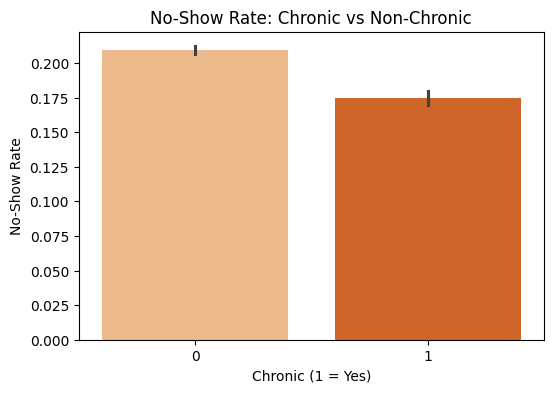

In [46]:
df_for_plots['Chronic'] = ((df_for_plots['Hypertension']==1) | (df_for_plots['Diabetes']==1)).astype(int)

plt.figure(figsize=(6,4))
sns.barplot(data=df_for_plots, x='Chronic', y='NoShow', palette='Oranges')
plt.title("No-Show Rate: Chronic vs Non-Chronic")
plt.xlabel("Chronic (1 = Yes)")
plt.ylabel("No-Show Rate")
plt.show()


**SMS Received vs No-Show**

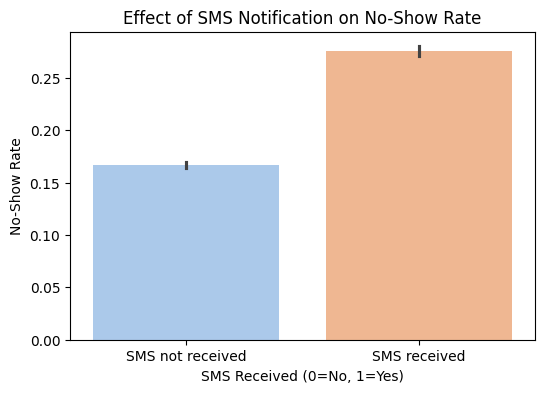

In [47]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_for_plots, x='SmsReceived', y='NoShow', palette='pastel')
plt.title("Effect of SMS Notification on No-Show Rate")
plt.xlabel("SMS Received (0=No, 1=Yes)")
plt.ylabel("No-Show Rate")
plt.show()


### Feature Engineering

In [63]:
df_clean = df.copy()

# gender
df_clean['Gender'] = df_clean['Gender'].map({'M':1, 'F':0})

# weekday mapping
weekday = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5}
df_clean['Appointment_Weekday'] = df_clean['AppointmentDayOfWeek'].map(weekday)
df_clean['Scheduled_Weekday'] = df_clean['ScheduledDayOfWeek'].map(weekday)

# hour
df_clean['Appointment_Hour'] = df_clean['AppointmentDay'].dt.hour

# Lead days — already exists
df_clean['LeadDays'] = df_clean['LeadDays'].clip(lower=0)

# target encoding for neighbourhood
neigh_rate = df_clean.groupby("Neighbourhood")["NoShow"].mean()
df_clean["Neighbourhood_TE"] = df_clean["Neighbourhood"].map(neigh_rate)

# final ML dataset
df_ml = df_clean[['NoShow','Gender','Age','Scholarship','Hypertension','Diabetes',
                  'Alcoholism','Handicap','SmsReceived','LeadDays',
                  'Appointment_Weekday','Scheduled_Weekday','Appointment_Hour',
                  'Neighbourhood_TE']]


In [64]:
X = df_ml.drop('NoShow', axis=1)
y = df_ml['NoShow']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


### RandomForestClassifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]


In [66]:
print("Accuracy:", round(met.accuracy_score(y_test, pred_rf),4))
print("AUC:", round(met.roc_auc_score(y_test, proba_rf),4))


Accuracy: 0.7763
AUC: 0.7153


### XGBClassifier

In [67]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)
proba_xgb = xgb.predict_proba(X_test)[:,1]


In [68]:
print("Accuracy:", round(met.accuracy_score(y_test, pred_xgb),4))
print("AUC:", round(met.roc_auc_score(y_test, proba_xgb),4))


Accuracy: 0.8004
AUC: 0.7381


**SHAP plots**

In [69]:
best_model = xgb  

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

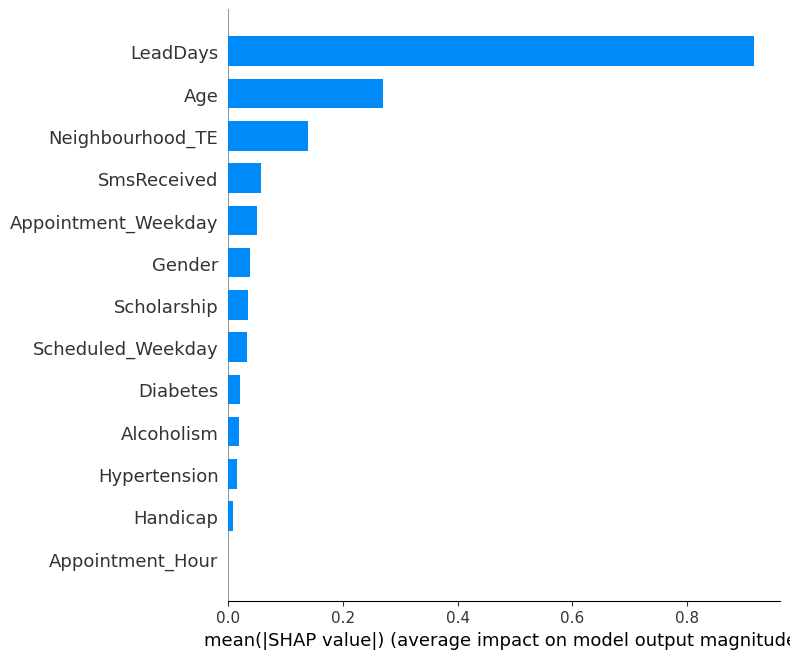

In [73]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


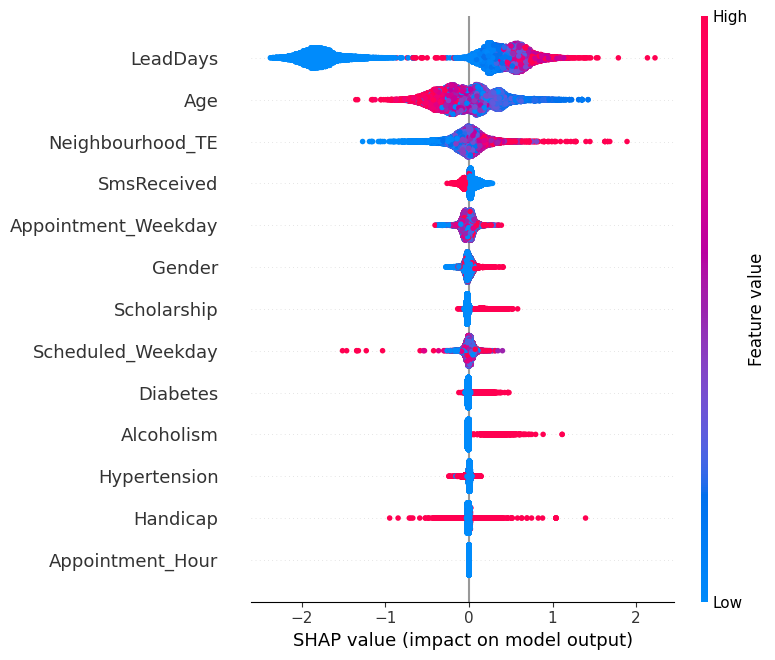

In [72]:
shap.summary_plot(shap_values, X_test)


### Predict No-Show 

In [74]:
df_clean["NoShow_Prob"] = best_model.predict_proba(X)[:,1]
df_clean["ShowUp_Prob"] = 1 - df_clean["NoShow_Prob"]


In [75]:
df_clean["Risk_Segment"] = pd.cut(
    df_clean["NoShow_Prob"],
    bins=[-0.001, 0.30, 0.60, 1.0],
    labels=["Low", "Medium", "High"]
)


In [76]:
df_clean[["PatientId","NoShow","NoShow_Prob","Risk_Segment"]].head(10)


,PatientId,NoShow,NoShow_Prob,Risk_Segment
0,2.987250e+13,0,0.015630,Low
1,5.589978e+14,0,0.018305,Low
2,4.262962e+12,0,0.032320,Low
3,8.679512e+11,0,0.095119,Low
4,8.841186e+12,0,0.013562,Low
5,9.598513e+13,0,0.160531,Low
6,7.336882e+14,1,0.320982,Medium
7,3.449833e+12,1,0.257162,Low
8,5.639473e+13,0,0.042151,Low
9,7.812456e+13,0,0.334835,Medium
